### Data Reduction & Analysis on Simulated Sattelite Data - Caleb Wilkins 11/01/2021

In [1]:
#imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import h5py
plt.rcParams["figure.figsize"] = (20,15)

This notebook contains a scientific data analysis experiment in which we are going to work with satellite data and explore how to estimate the background distribution of 'real' (i.e. messy) data. Real is in air quotes because the data is actually from a simulation rather than straight from a satellite, but this practice is common in astronomy. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the satellite relative to the ground, and particle counts. Each measurement represents the number of counts seen in a 0.1 second interval. Since we don't see gamma rays that often, most of these counts are cosmic rays.

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

In [3]:
df = pd.DataFrame(data).T
df.columns = ['GPS Time (s)', 'Solar Phase (deg)', 'Earth Longitude (deg)', 'Particle Counts']
df

,GPS Time (s),Solar Phase (deg),Earth Longitude (deg),Particle Counts
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


We'll begin by plotting a chunk of the data to visualize what the measurements look like. Taking cuts and subsets of the data we are working with is a hugely important part of analyzing big data sets, as it allows us to observe trends that help us understand the data without overloading our machine with the burden of plotting or computing mathematical analysis on millions or billions of data points. Thus, this strategy will be common throughout this experiment.

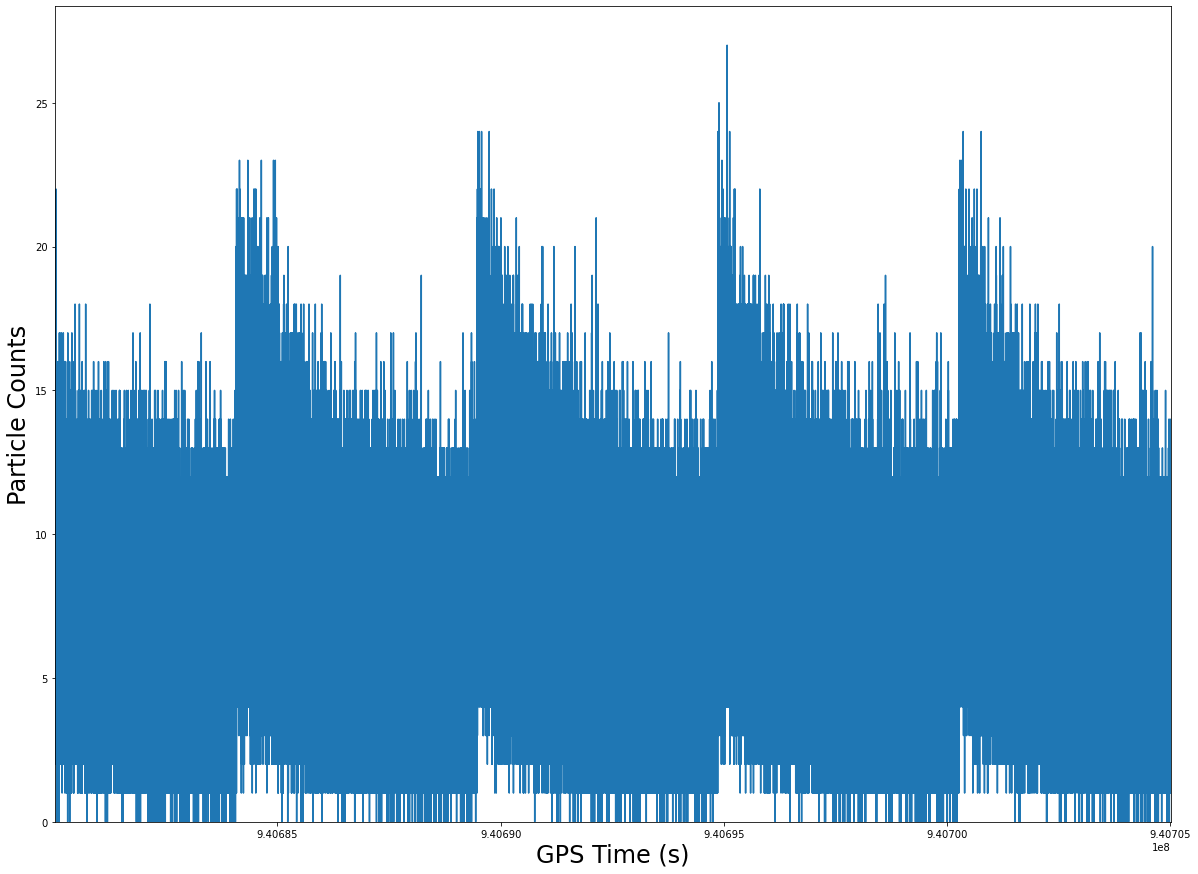

In [4]:
# We use a variable in order to be able to change the amount of data points
# we are plotting with ease at any later time
data_pts = 250000

fig, ax = plt.subplots(1,1)
plt.plot(data[0][0:data_pts], data[3][0:data_pts]);
plt.xlim(data[0][0], data[0][data_pts])
plt.xlabel('GPS Time (s)', fontsize=24)
plt.ylabel('Particle Counts', fontsize=24)
plt.ylim(0, None);

Periodic spikes in data could tell us of an interfering source we are periodically running into. Plotting the data in a normalized histogram should tell us about the nature of its distribution.

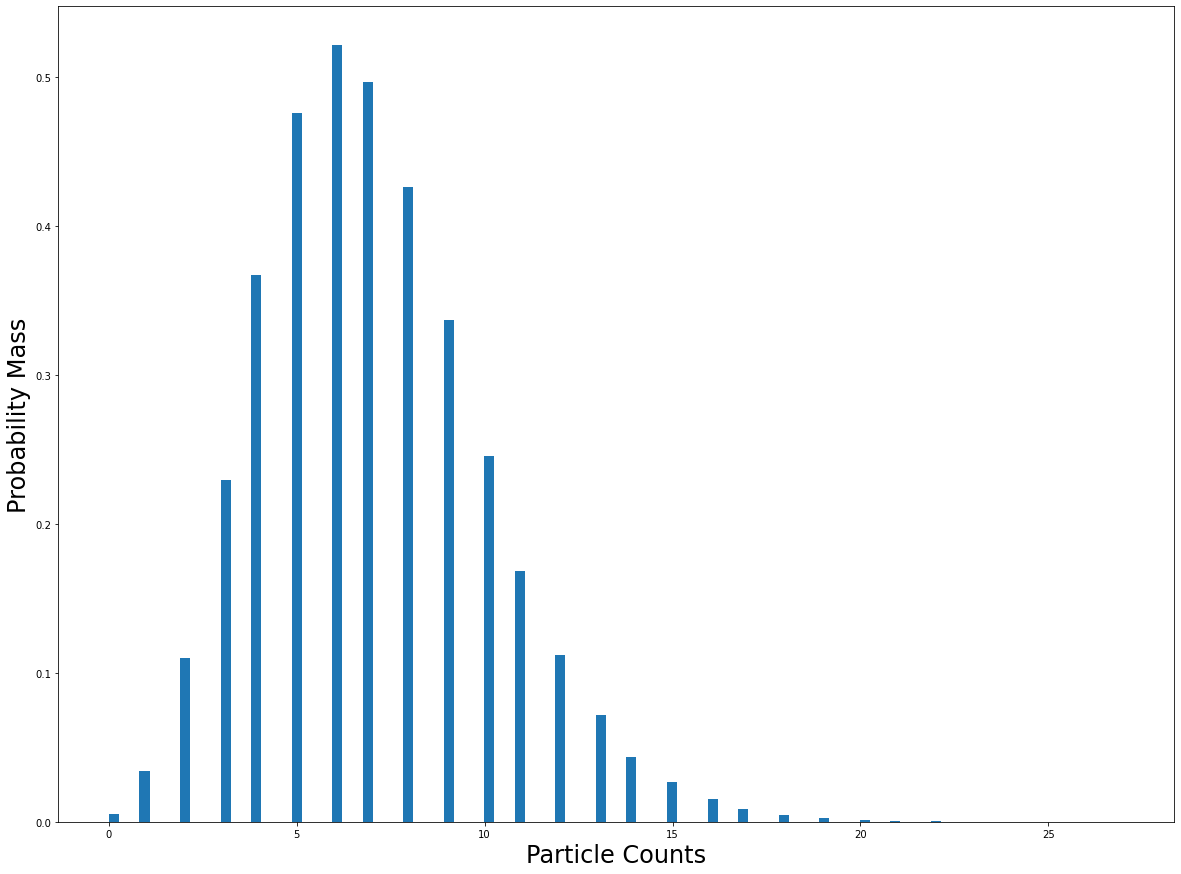

In [5]:
fig, ax = plt.subplots(1,1)
plt.hist(data[3][0:data_pts], bins=100, density=True)
plt.ylabel('Probability Mass', fontsize=24)
plt.xlabel('Particle Counts', fontsize=24)
plt.show();

This looks like a Poisson distribution, so let's compare it to such and test if we can categorize our background as Poisson distributed. The mean of our data looks to be about 6 (as in 6 particle counts per 100 milliseconds) so we will start with comparing it to a Poisson distribution with mean 6.

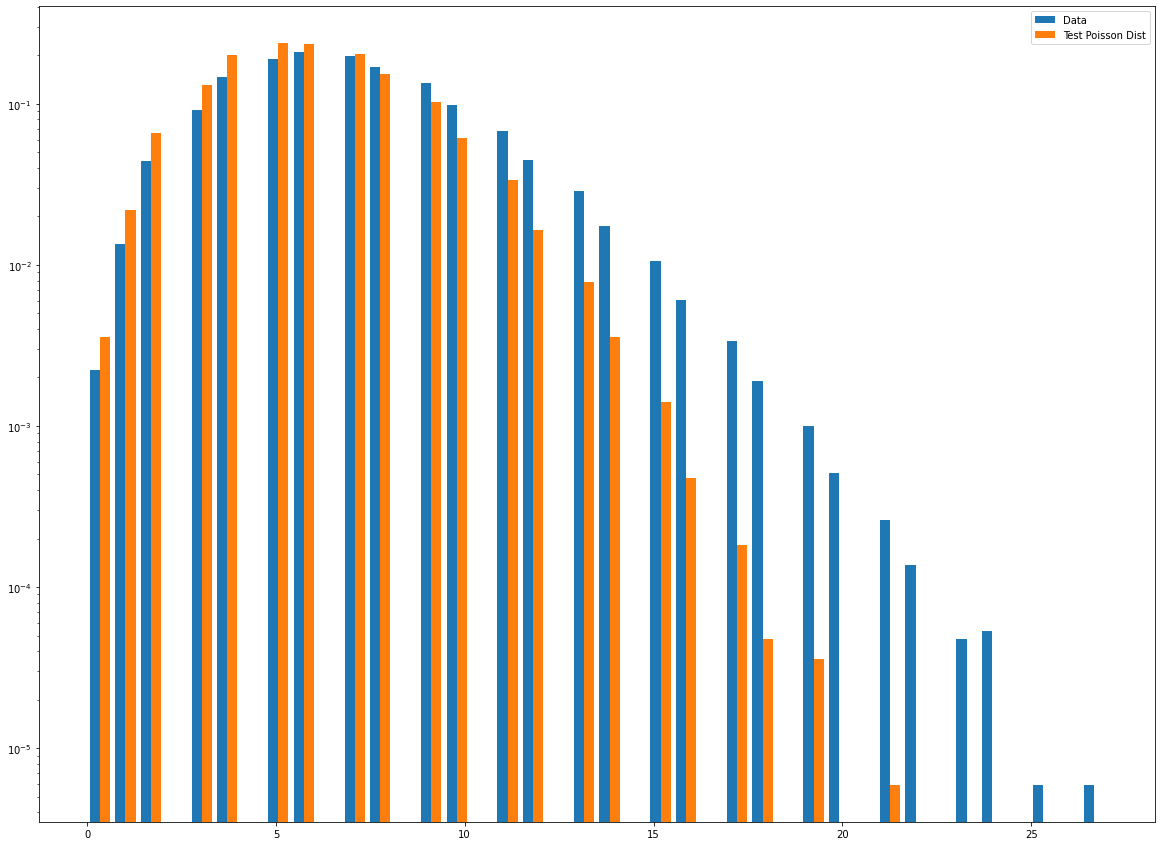

In [6]:
# We will use scipy to graph the Poissoin distribution we want to compare our data to
test_dist = stats.poisson(6)

# The 'rvs' function allows us to generate a random set of data points of a specified
# size, thus we use our data_pts variable again so that we are plotting distributions
# of the same size
test_vals = test_dist.rvs(data_pts)
plt.hist([data[3][0:data_pts], test_vals], bins=40, density=True)
plt.yscale('log')
plt.legend(['Data', 'Test Poisson Dist']);

As of now, the data has too much of a tail to be Poisson distributed, and there are unequal gaps throughout the distribution. We are going to have to keep investigating the data to learn more. Let's trying plotting each column we were given together to see what we can learn.

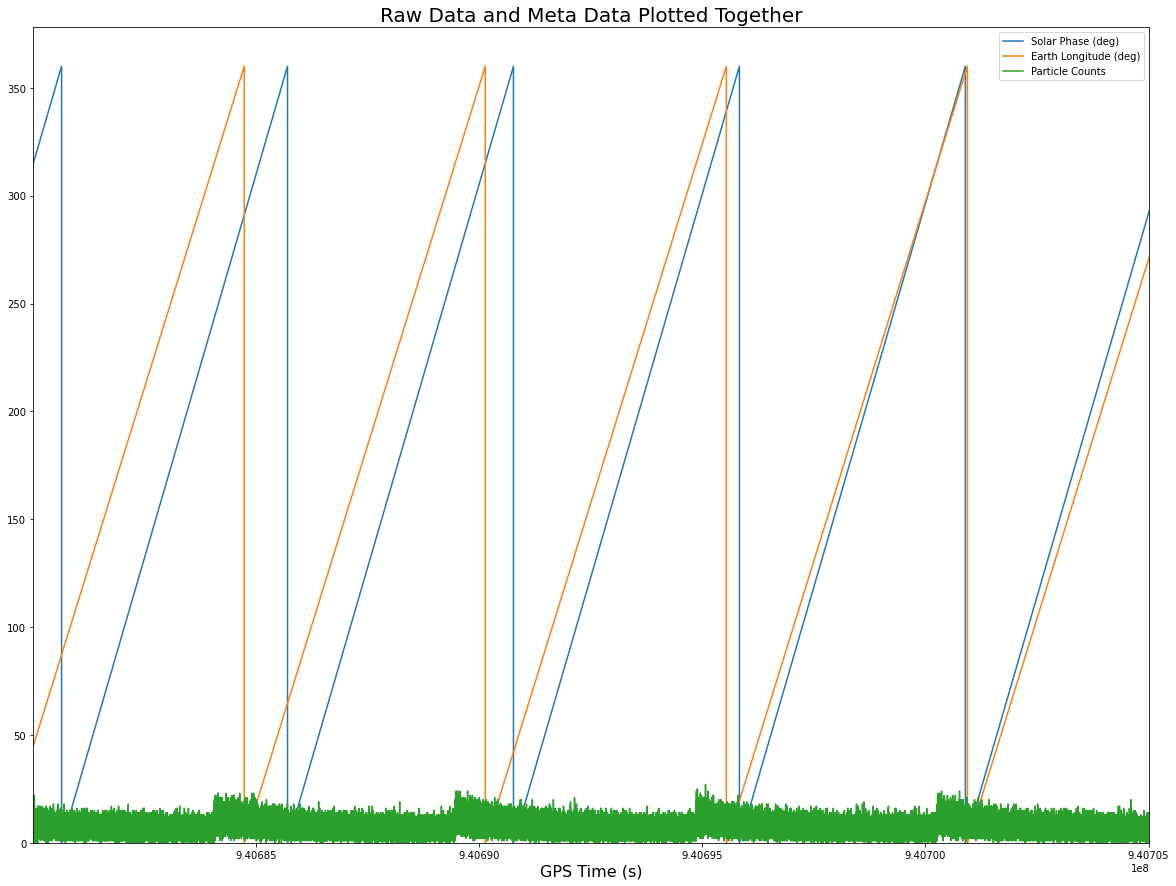

In [7]:
# Here we are plotting each column of the data on the same graph, this includes the raw data
# we want to analyze and the meta data that describes it. Note the legend on the graph.

fig,ax = plt.subplots(1,1)
plt.plot(data[0][0:data_pts], data[1][0:data_pts])
plt.plot(data[0][0:data_pts], data[2][0:data_pts])
plt.plot(data[0][0:data_pts], data[3][0:data_pts])
plt.xlim(data[0][0], data[0][data_pts])
plt.ylim(0,None)
plt.xlabel('GPS Time (s)', fontsize=16)
plt.title('Raw Data and Meta Data Plotted Together', fontsize=20)
plt.legend(['Solar Phase (deg)', 'Earth Longitude (deg)','Particle Counts'], loc=0);

The meta data shows a similar "spiking" pattern. Though, the solar phase doesn't seem to have much correlation with the raw data, so we can rule out the sun as a source of signal contamination - which is helpful. However, the Earth's longitude data and the spikes in the raw data appear to happen at the same frequency (with just a phase shift), so the period of the spikes in our signal (and those of the Earth's longitude) is about 5400 seconds, or 90 minutes, which is the orbital period for our satellite. Thus, during every orbital period, our satellite appears to be passing through some region at around 350 degrees longitude that gives us higher cosmic ray counts. By doing some poking around on Wikipedia, I found that there is an area of interest that stretches from about 310 degrees longitude to 360 degrees longitude, called the South Atlantic Anomaly (SAA). In this area, there is an increased flux of energetic particles and it exposes orbiting satellites to higher-than-usual levels of radiation. The effect is caused by the non-concentricity of Earth and its magnetic dipole. The SAA is the near-Earth region where Earth's magnetic field is weakest relative to an idealized Earth-centered dipole field. If we assume this is the cause of our signal contamination, we will need to separate data taken outside this region from data taken inside in order to find the 5-sigma threshold for a 100 millisecond gamma ray burst in each case.

In [8]:
# We will thus deploy cuts in our data to separate the data taken while the satellite was
# within the SAA from when it was not. We will then plot just the data taken outside this 
# proposed 'contaminated' region to observe if it makes our data more sensible.

no_saa_data = (data[2] > 40) & (data[2] < 315)
gps_time_no_saa = data[0][no_saa_data]
raw_data_no_saa = data[3][no_saa_data]
gps_time_in_saa = data[0][np.invert(no_saa_data)]
raw_data_in_saa = data[3][np.invert(no_saa_data)]

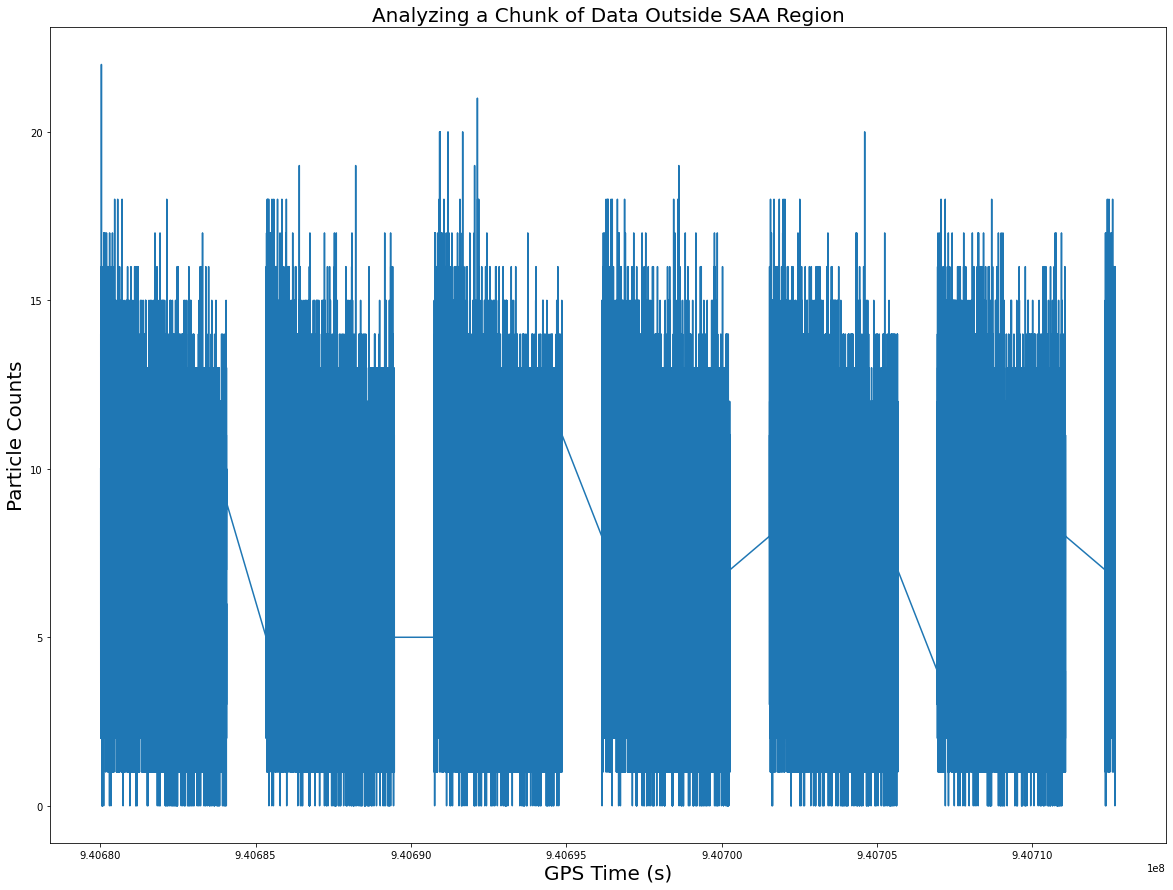

In [9]:
plt.plot(gps_time_no_saa[0:data_pts], raw_data_no_saa[0:data_pts])
plt.xlabel('GPS Time (s)', fontsize=20)
plt.ylabel('Particle Counts', fontsize=20)
plt.title('Analyzing a Chunk of Data Outside SAA Region', fontsize=20);

We have (mostly) elimanted the spikes, and the measurements now resemble a more obvious discrete distribution. Thus, let's now plot all the data outside the SAA region again against a Poisson distribution.

In [10]:
# Let's quickly find the exact mean of our 'uncontaminated' data using the numpy package
# so that the Poisson distribution we test our data against is the most accurate approximation
np.mean(raw_data_no_saa).round(2)

6.39

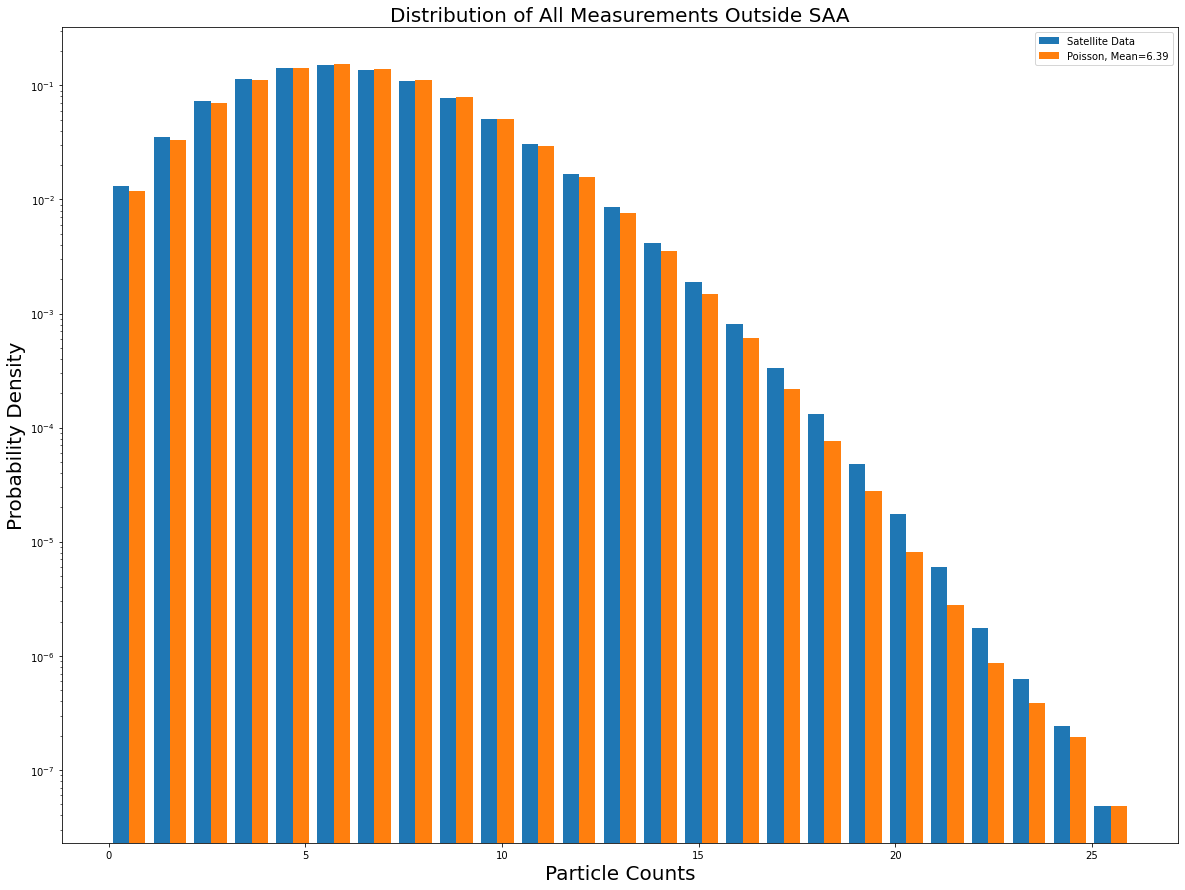

In [11]:
vals = stats.poisson(6.39).rvs(len(raw_data_no_saa))
plt.hist([raw_data_no_saa, vals], bins=25, density=True)
plt.xlabel('Particle Counts', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.title('Distribution of All Measurements Outside SAA', fontsize=20)
plt.yscale('log')
plt.legend(['Satellite Data', 'Poisson, Mean=6.39']);

Contrast to our prior attempt at modeling the entirety of the raw data as a Poisson distribution of mean ~6, when we use just the data taken outside the SAA region, we see that the model works fairly well. We can now use our usual method of using the ppf function to find the 5-sigma threshold of this region of the data.

In [12]:
print(f'The 5-sigma threshold for a 100 millisecond GRB outside the SAA region is {stats.poisson(6.39).ppf(stats.norm.cdf(5))}.')

The 5-sigma threshold for a 100 millisecond GRB outside the SAA region is 23.0.


Now, how about inside the SAA?

In [13]:
np.mean(raw_data_in_saa).round(2)

9.38

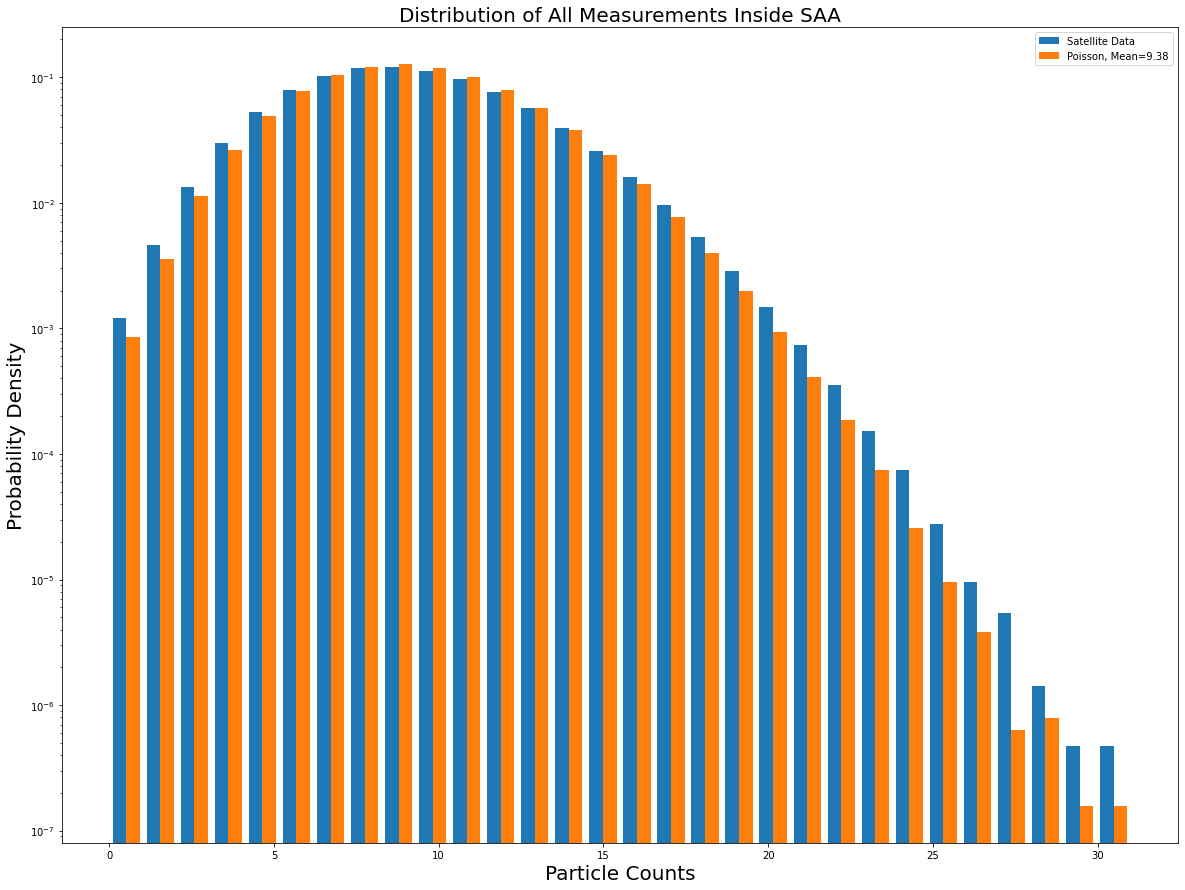

In [14]:
vals = stats.poisson(9.38).rvs(len(raw_data_in_saa))
plt.hist([raw_data_in_saa, vals], bins=30, density=True)
plt.xlabel('Particle Counts', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.title('Distribution of All Measurements Inside SAA', fontsize=20)
plt.yscale('log')
plt.legend(['Satellite Data', 'Poisson, Mean=9.38']);

We now see that isolating the data from outside the SAA and from inside the SAA, we can model our background as Poisson distributions with means equal to that of our raw data from outside or inside the SAA, respectively. 

In [15]:
print(f'The 5-sigma threshold for a 100 millisecond GRB inside the SAA region is {stats.poisson(9.38).ppf(stats.norm.cdf(5))}.')

The 5-sigma threshold for a 100 millisecond GRB inside the SAA region is 28.0.
